# Multiple Cora visualizations
In this tutorial, we will visualize the Cora graph using all of the available embedding methods that can embed Cora.

This will exclude methods that require edge types and weights.

## Retrieving the graph

In [1]:
from grape.datasets.linqs import Cora
graph = Cora()

In this version of Cora, we have integrated the words data.

Generally, in the embedding of Cora, the words information is excluded and used in classifier models down the line.

In [2]:
from grape.datasets.linqs import get_words_data

graph, _ = get_words_data(graph)

To get the graph report, just run:

In [3]:
graph

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>Cora</h2><p class="paragraph">The undirected graph Cora has 2.71K heterogeneous nodes and 5.28K edges. The graph contains 78 connected components, with the largest one containing 2.48K nodes and the smallest one containing 2 nodes. The RAM requirements for the nodes and edges data structures are 207.68KB and 16.34KB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 1, the maximum node degree is 168, the mode degree is 2, the mean degree is 3.90 and the node degree median is 3.</p><p class="paragraph">The nodes with the highest degree centrality are 35 (degree 168 and node type Genetic_Algorithms), 6213 (degree 78 and node type Reinforcement_Learning), 1365 (degree 74 and node type Neural_Networks), 3229 (degree 65 and node type Neural_Networks) and 910 (degree 44 and node type Neural_Networks).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has 7 node types, which are Neural_Networks (818 nodes, 30.21%), Probabilistic_Methods (426 nodes, 15.73%), Genetic_Algorithms (418 nodes, 15.44%), Theory (351 nodes, 12.96%), Case_Based (298 nodes, 11.00%), Reinforcement_Learning (217 nodes, 8.01%) and Rule_Learning (180 nodes, 6.65%). The RAM requirement for the node types data structure is 141.72KB.</p><h3 style="margin: 1em 0 0 0;">Topological Oddities</h3><p class="paragraph">A topological oddity is a set of nodes in the graph that <i>may be derived</i> by an error during the generation of the edge list of the graph and, depending on the task, could bias the results of topology-based models. In the following paragraph, we will describe the detected topological oddities.</p><h4 style="margin: 1em 0 0 0;">Node tuples</h4><p class="paragraph">A node tuple is a connected component composed of two nodes. We have detected 57 node tuples in the graph, involving a total of 114 nodes (4.21%) and 57 edges (0.54%). The detected node tuples are:</p><ul class="medium-columns"><li><p class="paragraph">Node tuple containing the nodes 1105622 (node type Neural_Networks) and 430574 (node type Neural_Networks).</p></li>
<li><p class="paragraph">Node tuple containing the nodes 116512 (node type Neural_Networks) and 1107808 (node type Neural_Networks).</p></li>
<li><p class="paragraph">Node tuple containing the nodes 1107728 (node type Neural_Networks) and 115188 (node type Neural_Networks).</p></li>
<li><p class="paragraph">Node tuple containing the nodes 1136040 (node type Neural_Networks) and 754594 (node type Neural_Networks).</p></li>
<li><p class="paragraph">Node tuple containing the nodes 73972 (node type Case_Based) and 50980 (node type Case_Based).</p></li>
<li><p class="paragraph">Node tuple containing the nodes 628458 (node type Neural_Networks) and 628459 (node type Neural_Networks).</p></li>
<li><p class="paragraph">Node tuple containing the nodes 180301 (node type Probabilistic_Methods) and 1110628 (node type Probabilistic_Methods).</p></li>
<li><p class="paragraph">Node tuple c

## Sorting the graph by decreasing node degree
Some of the TensorFlow embedding models use the TensorFlow NCE method, which requires the nodes to be sorted by occurrence.

In [4]:
graph = graph.sort_by_decreasing_outbound_node_degree()

## Splitting into training and test set

In [5]:
train, test = graph.get_node_label_holdout_graphs(train_size=0.7)
train.enable()

## Retrieving the available embedding methods

In [6]:
from grape import get_available_models_for_node_embedding

all_embedding_methods = get_available_models_for_node_embedding()
embedding_methods = all_embedding_methods[
    (~all_embedding_methods.requires_edge_types.astype(bool)) &
    (~all_embedding_methods.requires_edge_weights.astype(bool))
]

# We remove some models that either require some additional
# information or are simply currently work in progress.
embedding_methods = embedding_methods[
    ~embedding_methods.model_name.str.contains("SPINE") &
    ~embedding_methods.model_name.str.contains("WINE")
]

## Running the visualizations

Computing embedding:   0%|          | 0/36 [00:00<?, ?it/s]

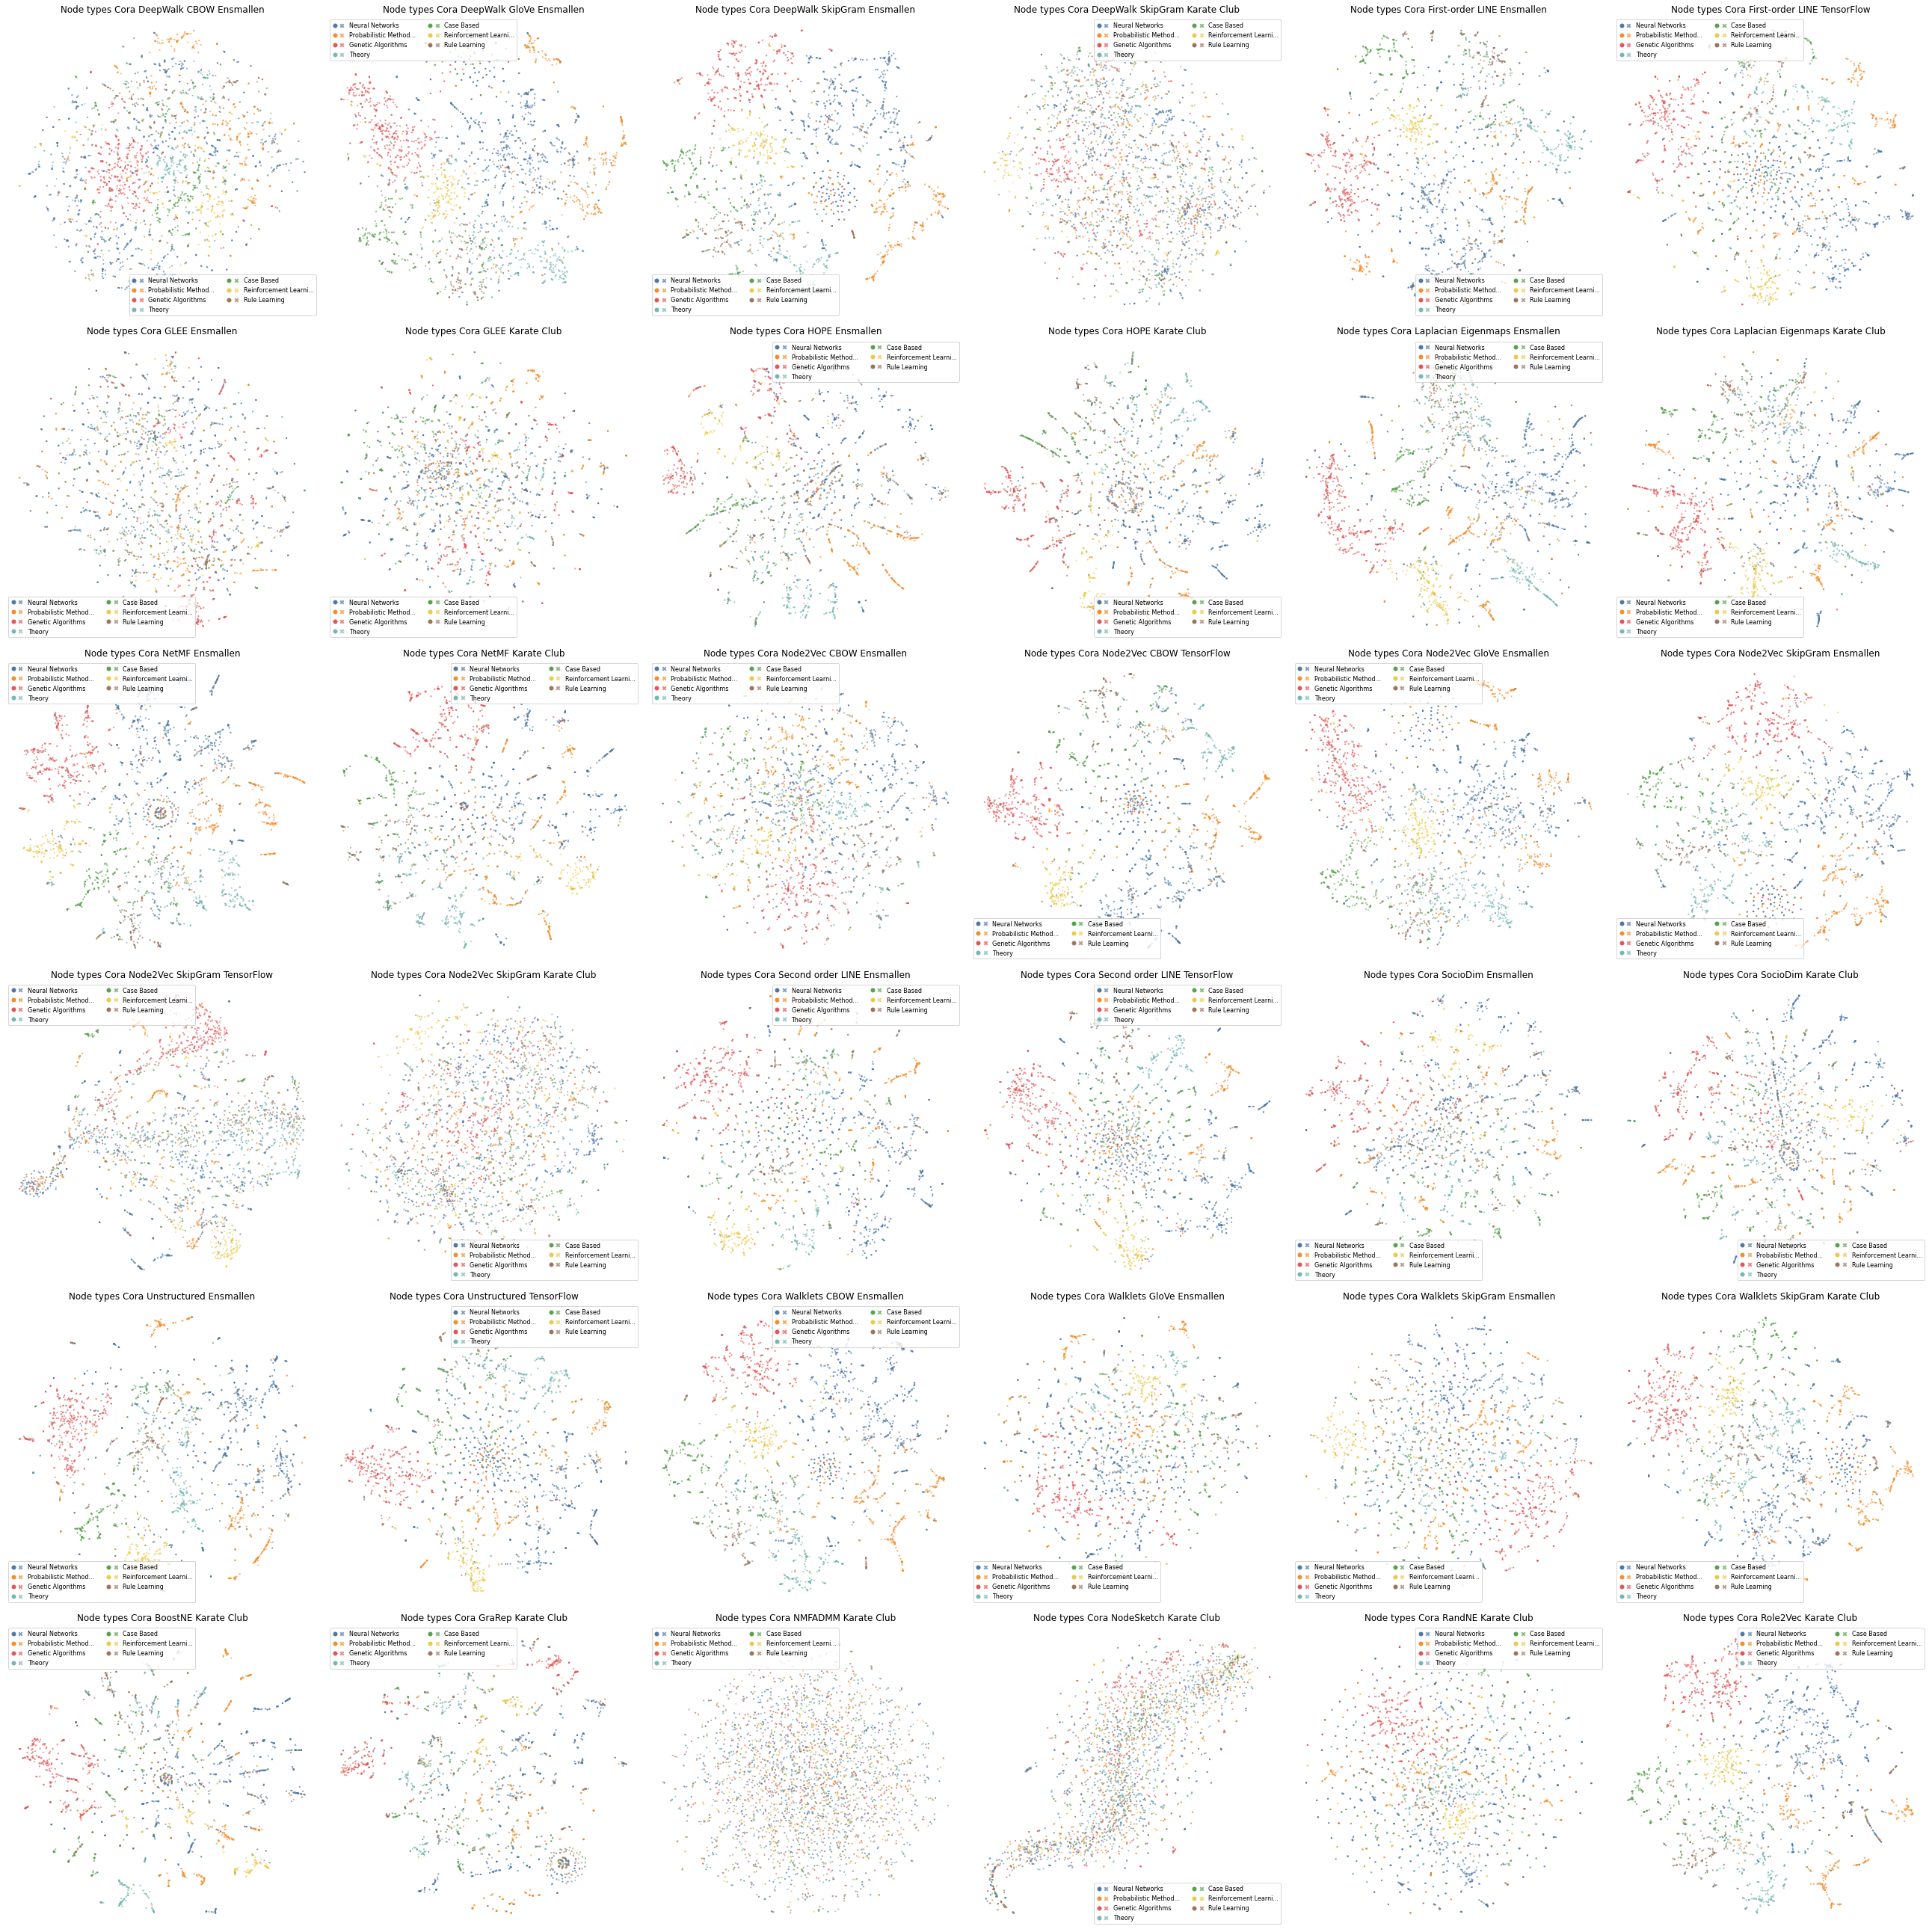

In [7]:
import silence_tensorflow.auto
from grape import GraphVisualizer
from grape.utils import AbstractEmbeddingModel
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from math import ceil

ncols = 6
nrows = ceil(embedding_methods.shape[0] / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

for index, (_, row) in tqdm(
    enumerate(embedding_methods.iterrows()),
    total=embedding_methods.shape[0],
    desc="Computing embedding"
):
    model = AbstractEmbeddingModel.get_model_from_library(
        model_name=row.model_name,
        library_name=row.library_name
    )(enable_cache=True)
    embedding = model.fit_transform(train)
    vis = GraphVisualizer(
        graph,
        node_embedding_method_name=f"{row.model_name} {row.library_name}",
        automatically_display_on_notebooks=False
    )
    vis.fit_nodes(embedding)
    vis.plot_node_types(
        figure=fig,
        axes=axes[index // ncols, index % ncols],
        train_indices=train.get_node_ids_with_known_node_types(),
        test_indices=test.get_node_ids_with_known_node_types()
    )
fig.tight_layout()
plt.show()